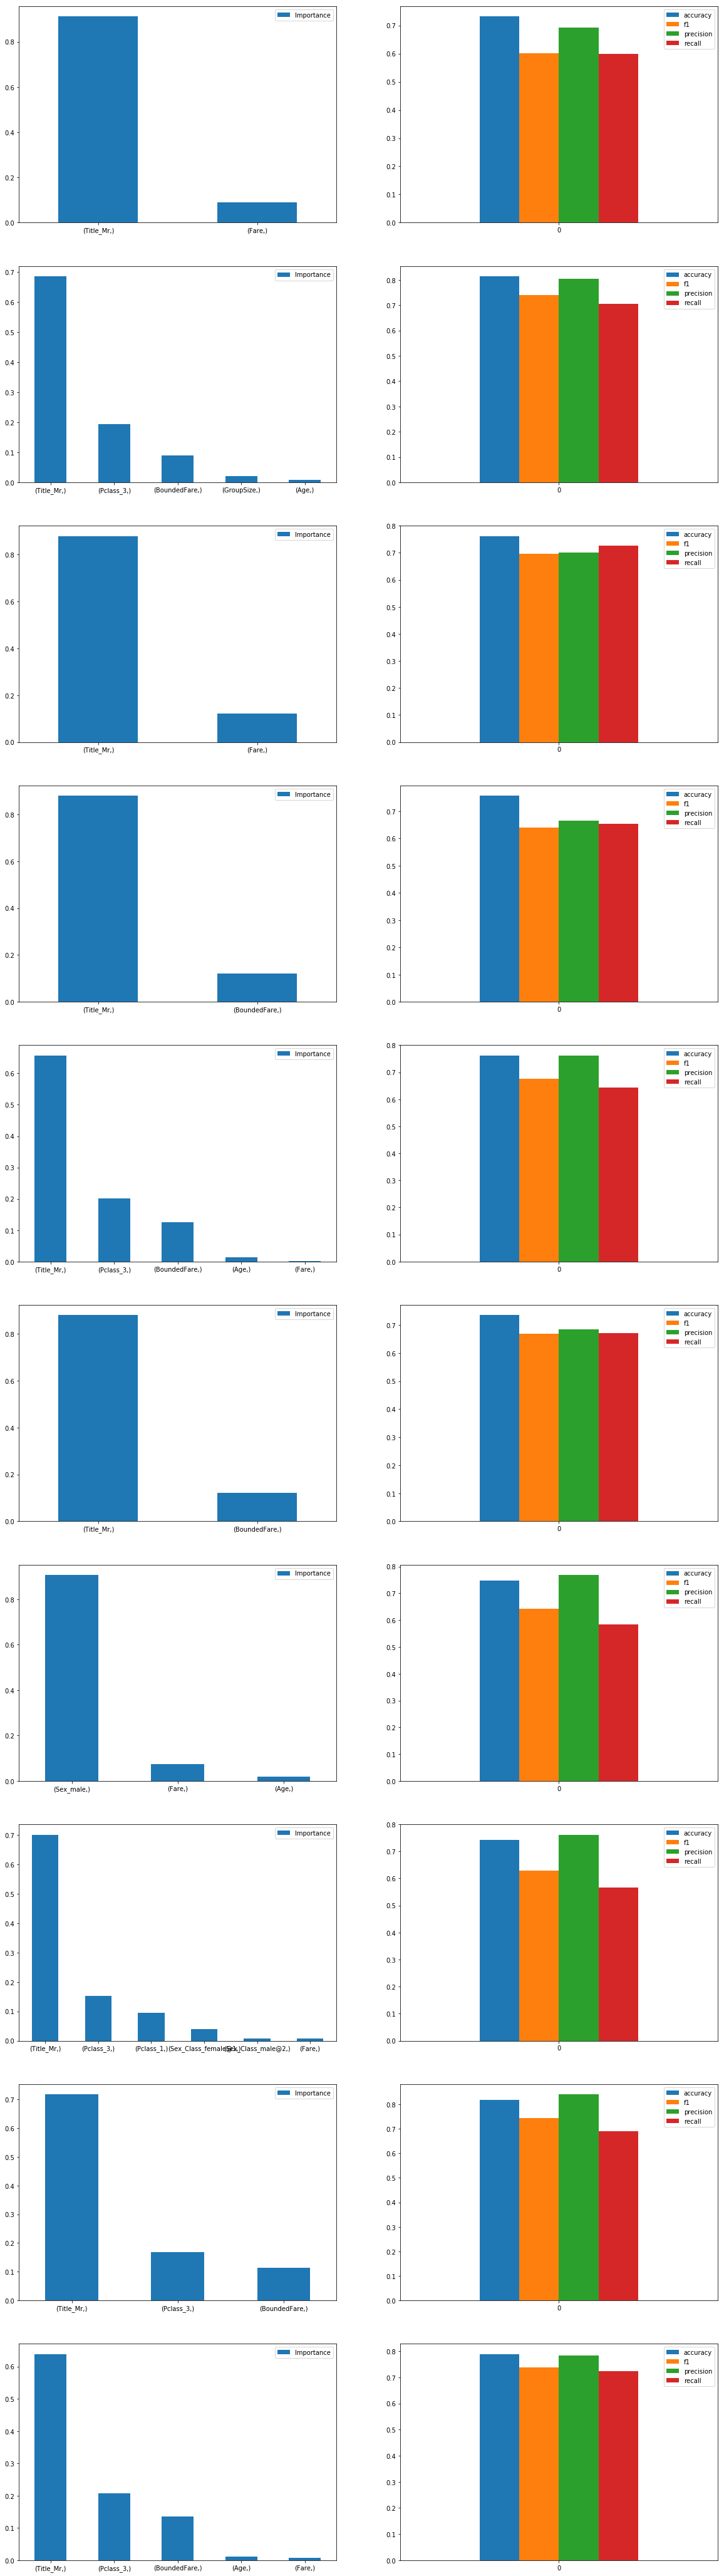

In [52]:
import itertools as it
import matplotlib
matplotlib.rc("lines", markeredgewidth=0.5) # This is required beacuse: http://bit.ly/2DEqYXt
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import tree, model_selection, metrics

from functional import curried
from analysis import *

@curried
def onehot_encode_notnull(columns, data):
    return pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=columns, sparse=False, drop_first=False)

def encode_age_group(df):
    return df.assign(AgeGroup = df['AgeGroup'].map(lambda interval: interval.left).astype(np.int32))

onehot_encode_features = onehot_encode_notnull(['Pclass', 'Sex', 'Embarked', 'Title', 'Sex_Class'])
encode_features = compose(onehot_encode_features, encode_age_group)

prepare_data = compose(
                 encode_features,
                 drop_columns(['Name', 'Cabin', 'Ticket', 'PassengerId', 'Survived']),
                 fill_fare,
                 add_bounded_fare(outlier_low=2, outlier_high=60),
                 fill_embarked,
                 add_age_group,
                 fill_age,
                 add_sex_and_class,
                 add_group_size,
                 add_cabin_size,
                 add_ticket_size,
                 add_family_size,
                 add_title
               )

def evaluate(model, params, features, labels):
    n_splits = 2
    n_repeats = 5
    cv = model_selection.RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    features_train, features_test, labels_train, labels_test = model_selection.train_test_split(features, labels, test_size=0.2)

    clf = model_selection.GridSearchCV(model, params, cv=cv, scoring='accuracy')
    clf.fit(features_train, labels_train)

    scoring = {
        'accuracy':  metrics.make_scorer(metrics.accuracy_score),
        'f1':        metrics.make_scorer(metrics.f1_score),
        'precision': metrics.make_scorer(metrics.precision_score),
        'recall':    metrics.make_scorer(metrics.recall_score)
    }
    validation = model_selection.cross_validate(clf.best_estimator_, features_test, labels_test, scoring=scoring, cv=cv)
    scores = { score: [np.mean(validation['test_{}'.format(score)])] for score in scoring.keys() }

    return (clf.best_estimator_, scores)

data_train = pd.read_csv('../data/train.csv')
data_test = pd.read_csv('../data/test.csv')
data_all = pd.concat([data_train, data_test], ignore_index=True)

survived = data_train['Survived']
data_all_fixed = prepare_data(data_all)

data_train_fixed = data_all_fixed[:len(data_train)]
data_test_fixed = data_all_fixed[len(data_train):]


model = tree.DecisionTreeClassifier(random_state=0)
params = {
    'criterion': ['entropy', 'gini'],
    'max_features': [None, 'auto'],
    'min_samples_split': [i / 10.0 for i in range(1, 10)],
    'min_samples_leaf': [i / 10.0 for i in range(1, 5)]
}

repeat = 10
_, ax = plt.subplots(nrows=repeat, ncols=2)
axes = list(it.chain(*ax))

for i in range(0,repeat):
    model, scores = evaluate(model, params, data_train_fixed, survived)

    importance = pd.DataFrame(index=[data_train_fixed.columns], data={'Importance': model.feature_importances_})
    importance = importance[importance['Importance'] > 0].sort_values(by=['Importance'], ascending=False)

    importance.plot.bar(ax=axes[i * 2], figsize=(20,75), rot=0)
    pd.DataFrame(scores).plot.bar(ax=axes[i * 2 + 1], rot=0)
    